Work in process ...

# A first possibility for OGGM to have a mass balance model with daily input (precipitation and temperature) and daily output via `get_daily_mb` or  `get_specific_daily_mb`

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_era5_daily_data, TIModel, BASENAMES, process_wfde5_data
from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq

cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = False

# this needs to be changed if working on another computer
working_dir = utils.gettempdir(dirname='OGGM_mb_type_intercomparison', reset=True)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

from oggm.utils import (floatyear_to_date, date_to_floatyear)


2021-03-02 09:03:32: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-03-02 09:03:32: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-03-02 09:03:32: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-03-02 09:03:32: oggm.utils: Checking the download verification file checksum...


we use the Hintereisferner, but it should work for every glacier:

In [2]:
# get HEF glacier>
df = ['RGI60-11.00897']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
gdir = gdirs[0]
h, w = gdir.get_inversion_flowline_hw()


2021-03-02 09:03:33: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-03-02 09:03:33: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-03-02 09:03:33: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.00.tar verified successfully.


we don't want hydro years here!

In [3]:
cfg.PARAMS['hydro_month_nh'] = 1


2021-03-02 09:03:33: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.


**we use the WFDE5 climate with daily temperature and precipitation and a changing lapse rate (data from ERA5)**

In [4]:
# TODO: WFDE5_daily_cru ... this needs to be adapted in OGGM base code
cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
process_wfde5_data(gdir, temporal_resol='daily') 
# could use here instead as well:
# process_era5_daily_data(gdir)
mb_type = 'mb_real_daily'
grad_type = 'var_an_cycle' # could use here as well 'cte'

2021-03-02 09:03:34: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `ERA5_daily`.
2021-03-02 09:03:34: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_wfde5_data
2021-03-02 09:03:46: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_lapserates_monthly.nc verified successfully.


In [5]:
gd_mb = TIModel(gdir, None, mb_type=mb_type, grad_type=grad_type)


get the precipitation factor by optimising the standard deviation:

In [6]:
pf_opt = scipy.optimize.brentq(optimize_std_quot_brentq, 0.05, 20, disp=True, xtol=0.1,
                                            args=(gd_mb, gdir))
print(pf_opt)

0.5697524382128214


get again the calibrated melt factor by minimising the bias of the direct glaciological observations:

In [7]:
melt_f_opt = scipy.optimize.brentq(minimize_bias, 1, 10000,
                                           disp=True, xtol=0.1,
                                            args=(gd_mb, gdir,
                                            pf_opt, False))
print(melt_f_opt)

180.0546832790916


In [8]:
gd_mb.melt_f = melt_f_opt
gd_mb.prcp_fac = pf_opt

In [9]:
spec_mb_daily = gd_mb.get_specific_daily_mb(heights=h, widths=w, year=np.arange(1980, 2019))
# just a quick check:
spec_mb_yearly = gd_mb.get_specific_mb(heights=h, widths=w,
                                         year=np.arange(1980,
                                                        2019))
spec_mb_daily_yearly_sum = []
for mb in spec_mb_daily:
    spec_mb_daily_yearly_sum.append(mb.sum())
np.testing.assert_allclose(spec_mb_daily_yearly_sum,
                           spec_mb_yearly, rtol=1e-4)
# daily specific mass balance summed up over the year is equal to the annual specific mass balance

/home/lilianschuster/Schreibtisch/PhD/WPA_MBmodels/massbalance-sandbox_toGithub/MBsandbox/mbmod_daily_oneflowline.py:1427: UserWarning: get_daily_mb has not been tested enough,
  warnings.warn('get_daily_mb has not been tested enough,')
/home/lilianschuster/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


this is a very stupid way to do this,  but it works:

In [10]:
j = 0
a = 1980
# we don't use hydro years here 
first_date = np.array('1980-01-01', dtype=np.datetime64)
pd_mb = pd.DataFrame(columns=['daily_specific_mb', 'year'])
for mb_d in spec_mb_daily:
    
    for m in mb_d:
        pd_mb.loc[first_date + j] = m
        pd_mb.loc[first_date + j, 'year'] = a
        j += 1
    a+=1

In [13]:
pd_mb.groupby(pd_mb.index.month).mean()

,daily_specific_mb,year
1,2.958956,1999.000000
2,2.547365,1998.990926
3,2.966777,1999.000000
4,2.967157,1999.000000
5,0.379445,1999.000000
6,-7.744128,1999.000000
7,-16.983162,1999.000000
8,-17.491223,1999.000000
9,-5.613537,1999.000000
10,-0.205362,1999.000000


In [12]:
pd_mb.groupby(pd_mb.index.day_of_year).mean()

,daily_specific_mb,year
1,2.596468,1999.0
2,3.466918,1999.0
3,2.388884,1999.0
4,4.513055,1999.0
5,3.868611,1999.0
...,...,...
362,2.897789,1999.0
363,3.356953,1999.0
364,2.578425,1999.0
365,2.376220,1999.0


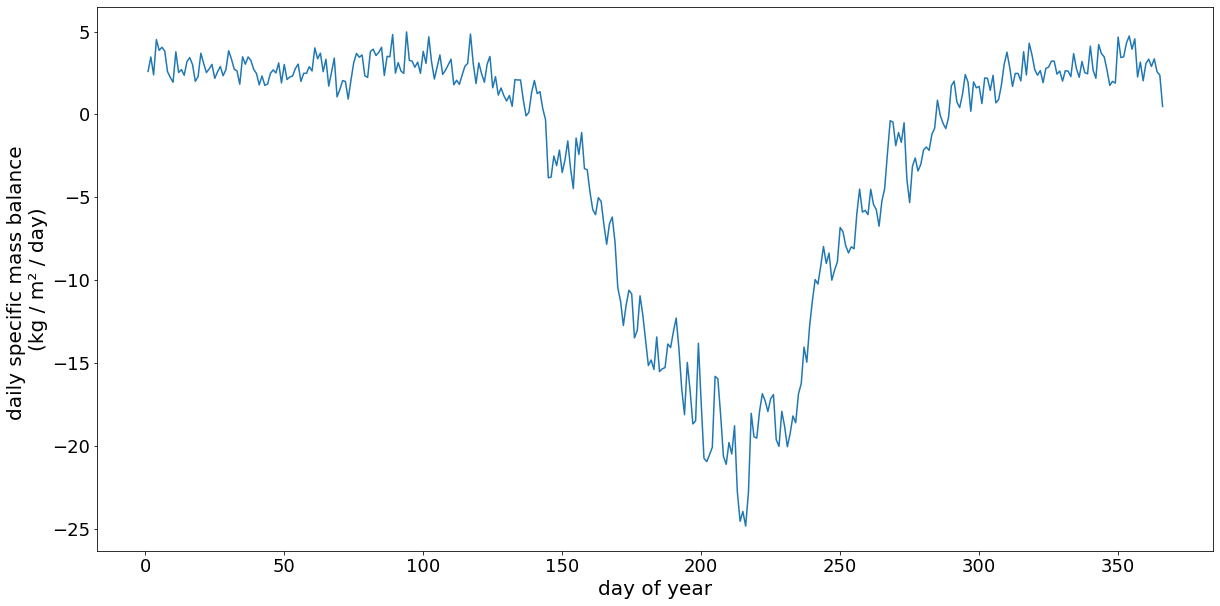

In [92]:
plt.figure(figsize=(20,10))
plt.plot(pd_mb.groupby(pd_mb.index.day_of_year).mean()['daily_specific_mb'])
plt.xlabel('day of year')
plt.ylabel('daily specific mass balance \n(kg / m² / day)');

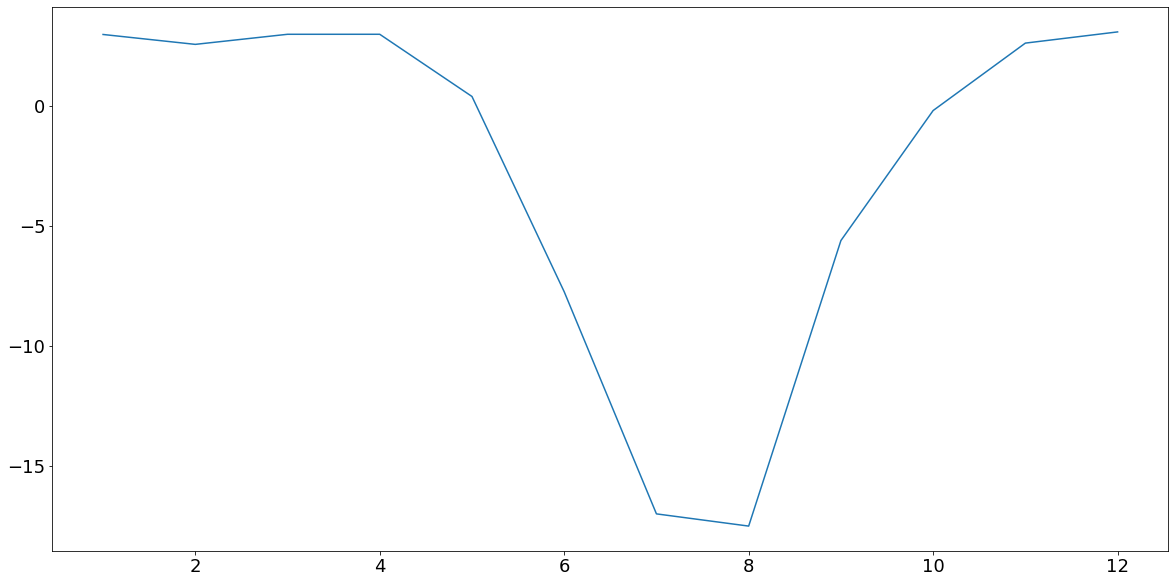

In [14]:
plt.figure(figsize=(20,10))

plt.plot(pd_mb.groupby(pd_mb.index.month).mean()['daily_specific_mb'])